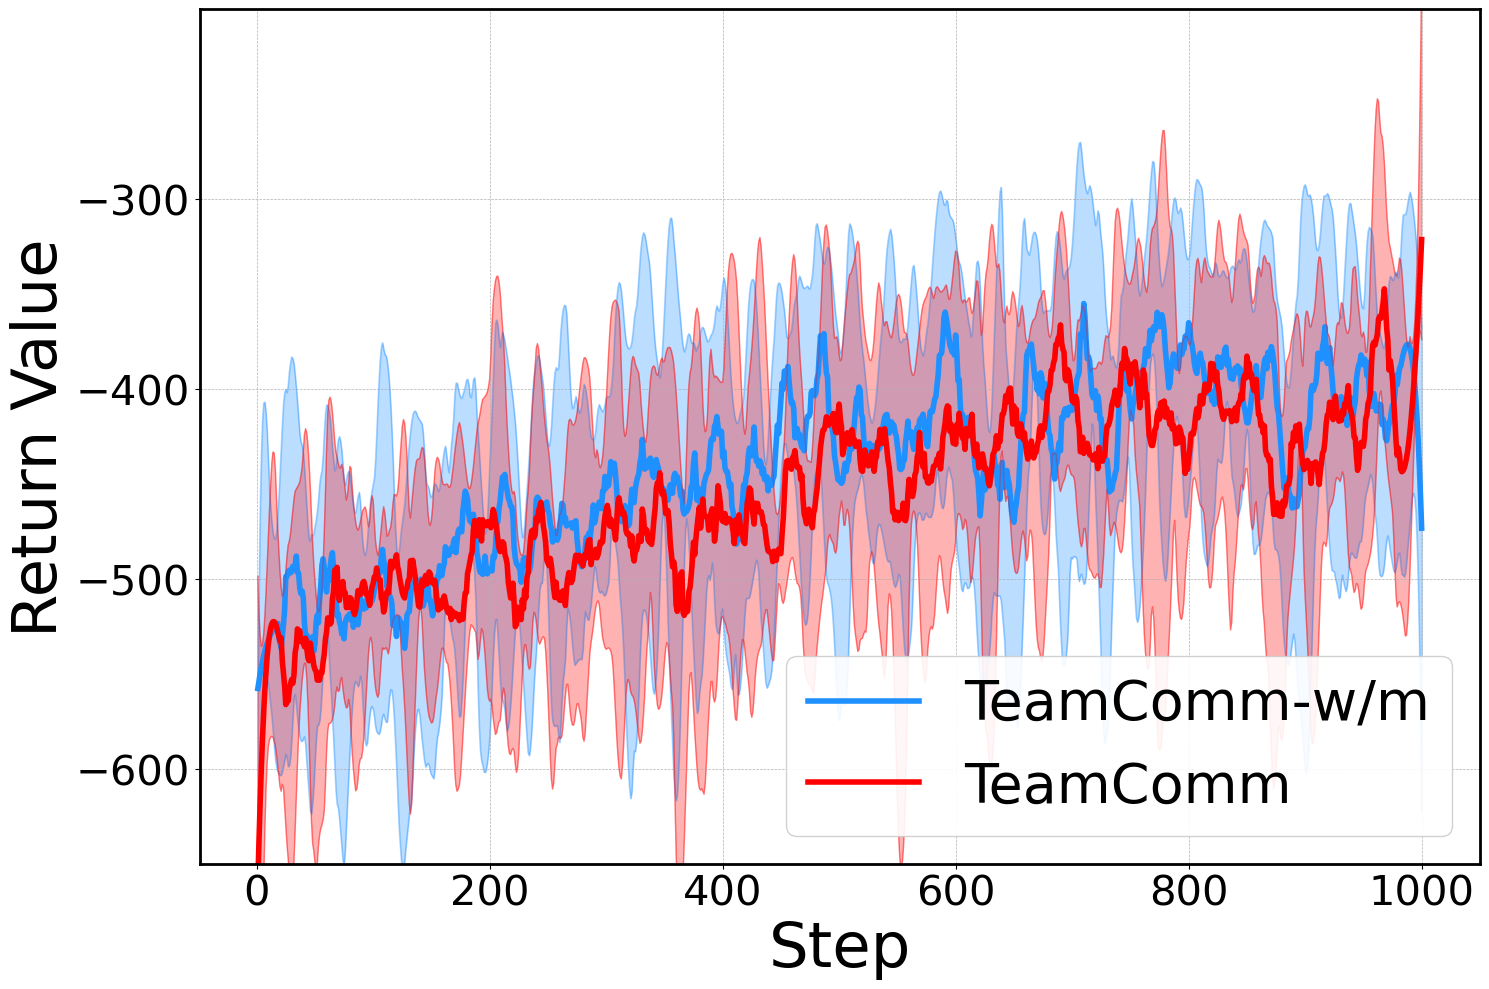

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema, savgol_filter
from scipy.interpolate import interp1d

# Load the mTF.csv file
df_mTF = pd.read_csv('wan.csv')

# Filtering columns that contain "episode_return" and ignoring those with "__MIN" or "__MAX"
selected_columns_mTF = [col for col in df_mTF.columns if "episode_return" in col and "__MIN" not in col and "__MAX" not in col]

# Extracting the data for the selected columns
x_mTF = df_mTF['epoch']

# Define the smoothing and bound calculation function
def compute_smoothed_bounds(data, x, window_size_bounds, poly_order):
    upper_idx = argrelextrema(data.to_numpy(), np.greater)[0]
    lower_idx = argrelextrema(data.to_numpy(), np.less)[0]
    
    upper_points_x = x.iloc[upper_idx]
    upper_points_y = data.iloc[upper_idx]
    lower_points_x = x.iloc[lower_idx]
    lower_points_y = data.iloc[lower_idx]
    
    upper_interp = interp1d(upper_points_x, upper_points_y, kind='linear', fill_value='extrapolate')
    lower_interp = interp1d(lower_points_x, lower_points_y, kind='linear', fill_value='extrapolate')
    
    upper_bound = upper_interp(x)
    lower_bound = lower_interp(x)
    
    smoothed_upper_bound = savgol_filter(upper_bound, window_size_bounds, poly_order)
    smoothed_lower_bound = savgol_filter(lower_bound, window_size_bounds, poly_order)
    
    return smoothed_upper_bound, smoothed_lower_bound

# Define parameters for smoothing
window_size_data = 35
window_size_bounds = 21  # Adjusted to ensure it's odd
poly_order = 3

# Adjusted distinct colors for the two lines
distinct_colors_mTF = ['dodgerblue', 'red']
custom_names_mTF = ["TeamComm-w/m", "TeamComm"]

# Plot initialization and rendering
plt.figure(figsize=(15, 10))
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
cu = 2
ax = plt.gca()
ax.spines['bottom'].set_linewidth(cu)
ax.spines['left'].set_linewidth(cu)
ax.spines['right'].set_linewidth(cu)
ax.spines['top'].set_linewidth(cu)

# Process and plot each of the data columns
for idx, column in enumerate(selected_columns_mTF):
    data_mTF = df_mTF[column].dropna()  # Removing NaN values
    x_data_mTF = x_mTF[:len(data_mTF)]
    
    smoothed_upper_bound_mTF, smoothed_lower_bound_mTF = compute_smoothed_bounds(data_mTF, x_data_mTF, window_size_bounds, poly_order)
    smoothed_data_mTF = savgol_filter(data_mTF, window_size_data, poly_order)
    
    # Plotting bounds
    plt.plot(x_data_mTF, smoothed_upper_bound_mTF, color=distinct_colors_mTF[idx], linewidth=1, alpha=0.3)
    plt.plot(x_data_mTF, smoothed_lower_bound_mTF, color=distinct_colors_mTF[idx], linewidth=1, alpha=0.3)
    
    # Filling between bounds
    plt.fill_between(x_data_mTF, smoothed_upper_bound_mTF, smoothed_lower_bound_mTF, color=distinct_colors_mTF[idx], alpha=0.3)
    
    # Plotting smoothed data
    plt.plot(x_data_mTF, smoothed_data_mTF, label=custom_names_mTF[idx], color=distinct_colors_mTF[idx], linewidth=4)

# Customize and show plot
plt.legend(loc='lower right', fontsize=40, framealpha=0.9)
plt.xlabel('Step', fontsize=45)
plt.ylabel('Return Value', fontsize=45)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(bottom=-650, top=-200 )
yticks = np.arange(-600, plt.gca().get_ylim()[1]+100 , 100)
plt.yticks(yticks, fontsize=30)
if len(yticks) > 1:
    plt.yticks(yticks[:-1], fontsize=30)
plt.tight_layout()
plt.show()
